In [232]:
%matplotlib inline

import collections
import copy
import glob
import json
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
seaborn.set_style("whitegrid")

In [233]:
base_dirpath = "/home/ubuntu/experiments/procgen_001"

In [234]:
EASY_GAME_RANGES = {
    'coinrun': [0, 5, 10],
    'starpilot': [0, 2.5, 64],
    'caveflyer': [0, 3.5, 12],
    'dodgeball': [0, 1.5, 19],
    'fruitbot': [-12, -1.5, 32.4],
    'chaser': [0, .5, 13],
    'miner': [0, 1.5, 13],
    'jumper': [0, 1, 10],
    'leaper': [0, 1.5, 10],
    'maze': [0, 5, 10],
    'bigfish': [0, 1, 40],
    'heist': [0, 3.5, 10],
    'climber': [0, 2, 12.6],
    'plunder': [0, 4.5, 30],
    'ninja': [0, 3.5, 10],
    'bossfight': [0, .5, 13],
    'caterpillar': [0, 8.25, 24],
    'gemjourney': [0, 1.1, 16],
    'hovercraft': [0, 0.2, 18],
    'safezone': [0, 0.2, 10],
}

In [235]:
def recursive_underscore_join_list(lst):
    result = ""
    for i, item in enumerate(lst):
        append = "_"
        if isinstance(item, list):
            item = recursive_underscore_join_list(item)
            append = "__"
        else:
            item = str(item)
        result += item
        if i < len(lst) - 1:
            result += append
    return result

def flatten_string_key_dict(d):
    result = dict()
    for k, v in d.items():
        if isinstance(v, dict):
            v = flatten_string_key_dict(v)
            for kk, vv in v.items():
                flat_key = f"{k}_{kk}"
                if isinstance(vv, list):
                    vv = recursive_underscore_join_list(vv)
                result[flat_key] = vv
        elif isinstance(v, list):
            result[k] = recursive_underscore_join_list(v)
        else:
            result[k] = v
    return result

def load_params_as_dataframe(filepath):
    with open(filepath, "r") as infile:
        params = json.load(infile)
        params = flatten_string_key_dict(params)
        return pd.DataFrame(params, index=[0])

def extract_relevant_info_from_row(row):
    info = dict()
    info["episode_reward_mean"] = row["episode_reward_mean"]
    if "evaluation" in row:
        info["evaluation_episode_reward_mean"] = row["evaluation"]["episode_reward_mean"]
    return info

def load_results_as_dataframe(filepath):
    data = []
    with open(filepath, "r") as infile:
        for row in infile:
            parsed = json.loads(row)
            parsed = extract_relevant_info_from_row(parsed)
            data.append(parsed)
    return pd.DataFrame(data)

class Run:
    def __init__(self, params, results):
        self.params = params
        self.results = results
        
    def as_row(self):
        """Returns a representation / summary of this run that can be used as a single row."""
        row = self.params.copy()
        if "evaluation_episode_reward_mean" in self.results:
            row["evaluation_episode_reward_mean"] = list(self.results["evaluation_episode_reward_mean"].dropna())[-1]
        return row
        
    def __len__(self):
        return len(self.results)
    
    @property
    def env(self):
        return self.params["env_config_env_name"].values[0]
    
    @classmethod
    def from_filepaths(cls, params_filepath, results_filepath, min_num_iter=400):
        assert os.path.exists(params_filepath)
        assert os.path.exists(results_filepath)
        params = load_params_as_dataframe(params_filepath)
        results = load_results_as_dataframe(results_filepath)
        if len(results) < min_num_iter:
            return None
        return cls(params, results)
    
    def with_normalized_results(self):
        norm_results = self.results.copy()
        min_r, blind_r, max_r = EASY_GAME_RANGES[self.env]
        norm_results = (norm_results - blind_r) / (max_r - blind_r)
        return Run(self.params, norm_results)

In [236]:
test_filepath = "/home/ubuntu/experiments/procgen_001/bigfish/bigfish_itr_0_cnn_lr_0.0005_filters_32_48_64_num_work_7_num_envs_per_125_rollout_len_16_minibatch_1750_rt_vf_loss_coeff_0.25_grad_clip_constant_5.0_1.0_intrins_reward_noop_10_phasic_32_2_simple_0_detach_False_w_data_aug_adapt_ent_0.9_0.02/custom_DataAugmentingPPOTrainer_custom_procgen_env_wrapper_0_2021-01-02_22-29-03i24qltk1"
params_filepath = os.path.join(test_filepath, "params.json")
result_filepath = os.path.join(test_filepath, "result.json")

In [237]:
r = Run.from_filepaths(params_filepath, result_filepath)
print(r)

In [238]:
for kvp in r.params.items():
    print(kvp[1])

0    True
Name: adapt_policy_parameters, dtype: bool
0    0.02
Name: adapt_policy_parameters_options_alternate_entropy_coeff, dtype: float64
0    0.9
Name: adapt_policy_parameters_options_unique_fraction_threshold, dtype: float64
0    False
Name: auto_drac_options_active, dtype: bool
0    
Name: auto_drac_options_always_use_transforms, dtype: object
0    random_translate_random_rotation_random_flip_l...
Name: auto_drac_options_choose_between_transforms, dtype: object
0    ucb
Name: auto_drac_options_learner_class, dtype: object
0    return
Name: auto_drac_options_ucb_options_internal_reward_mode, dtype: object
0    0.25
Name: auto_drac_options_ucb_options_lmbda, dtype: float64
0    0.05
Name: auto_drac_options_ucb_options_mean_reward_alpha, dtype: float64
0    16
Name: auto_drac_options_ucb_options_num_steps_per_update, dtype: int64
0    0.01
Name: auto_drac_options_ucb_options_q_alpha, dtype: float64
0    0.01
Name: auto_drac_options_ucb_options_ucb_c, dtype: float64
0    32
Name: aux

In [239]:
runs = []
for root, dirs, filenames in os.walk(base_dirpath):
    if "result.json" in filenames and "params.json" in filenames:
        params_filepath = os.path.join(root, "params.json")
        results_filepath = os.path.join(root, "result.json")
        run = Run.from_filepaths(params_filepath, results_filepath)
        if run is not None:
            runs.append(run)
print(len(runs))

32


In [240]:
ENV_NAMES = list(set(r.env for r in runs))
print(ENV_NAMES)

['climber', 'ninja', 'starpilot', 'plunder', 'bigfish', 'miner', 'bossfight', 'jumper', 'chaser', 'dodgeball', 'maze', 'caveflyer', 'heist', 'coinrun', 'leaper', 'fruitbot']


# Plot per-run performance

In [241]:
def plot_run(run, ax, key, label):
    y = run.results[key]
    x = range(len(y))
    ax.plot(x, y, alpha=0.8, label=label)
    ax.set_title(run.env)
    if label is not None:
        ax.legend()

def plot_runs(runs, key="episode_reward_mean", label=None, make_figure=True):
    if make_figure:
        fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    else:
        fig = plt.gcf()
        axs = fig.get_axes()
        axs = np.reshape(axs, (4, 4))
    for run in runs:
        ax_index = ENV_NAMES.index(run.env)
        ax_row = ax_index // 4
        ax_col = ax_index % 4
        plot_run(run, axs[ax_row, ax_col], key, label=label)

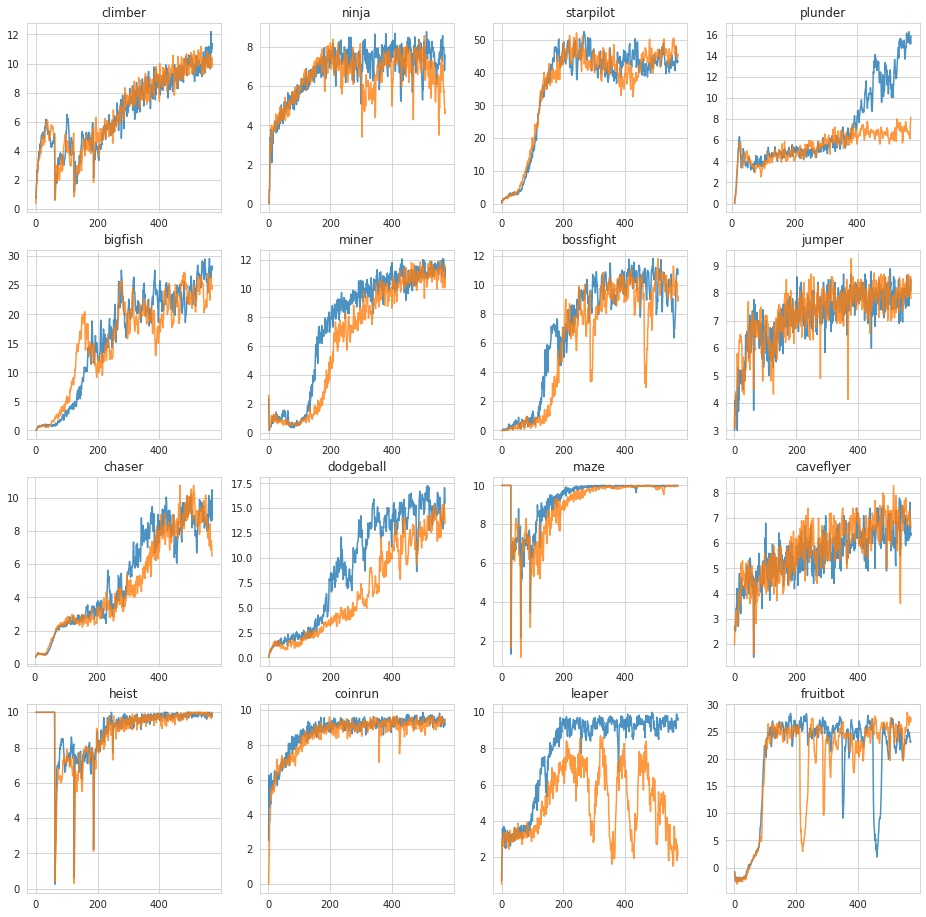

In [242]:
plot_runs(runs)

# Plot aggregate performance

In [243]:
class AggregateRun:
    def __init__(self, runs, field, value):
        self.runs = runs
        self.field = field
        self.value = value
        
    def for_env(self, env):
        return AggregateRun([r for r in self.runs if r.env == env], self.field, self.value)
    
    def with_normalized_results(self):
        return AggregateRun([r.with_normalized_results() for r in self.runs], self.field, self.value)
            
    def __repr__(self):
        return f"{self.field}: {self.value}"
    
    def __len__(self):
        return len(self.runs)

def aggregate_runs(runs, aggregation_key):
    aggregate_runs = collections.defaultdict(list)
    for run in runs:
        if aggregation_key not in run.params:
            aggregate_runs["missing"].append(run)
        else:
            key = tuple(str(v) for v in run.params[aggregation_key].values)
            aggregate_runs[key].append(run)
    aggregate_runs = [AggregateRun(v, aggregation_key, k) for (k, v) in aggregate_runs.items()]
    return aggregate_runs

In [244]:
aggregation_key = "aux_loss_num_sgd_iter"
agg_runs = aggregate_runs(runs, aggregation_key)

In [245]:
print(agg_runs)

[aux_loss_num_sgd_iter: ('2',)]


In [246]:
def plot_agg_run(agg_run, ax, key):
    if len(agg_run) == 0:
        return
    min_len = min(len(r) for r in agg_run.runs)
    values = [r.results[key][:min_len].dropna() for r in agg_run.runs]
    min_len = min(len(v) for v in values)
    values = [v[:min_len] for v in values]
    print(f"Final minimum length: {min_len}")
    if len(values) > 1:
        mean = np.mean(values, axis=0)
        values = np.array([np.array(v) for v in values])
        stderr = np.std(values, axis=0) / np.sqrt(len(values))
        ybelow = mean - stderr
        yabove = mean + stderr
    else:
        mean = np.array(values).reshape(-1)
        ybelow = None
        yabove = None
    
    x = range(len(mean))
    ax.plot(x, mean, label=f"{agg_run.value}")
    if ybelow is not None and yabove is not None:
        ax.fill_between(x, y1=yabove, y2=ybelow, label=f"{agg_run.value}", alpha=0.5)
    ax.set_title(agg_run.runs[0].env)

def plot_agg_runs(agg_runs, key="episode_reward_mean", average_envs=False):
    if average_envs:
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        for agg_run in agg_runs:
            plot_agg_run(agg_run.with_normalized_results(), ax, key=key)
        ax.legend()
        plt.title(f"{key} averaged over envs")
    else:
        fig, axs = plt.subplots(4, 4, figsize=(16, 16))
        for i, env_name in enumerate(ENV_NAMES):
            ax_row = i // 4
            ax_col = i % 4
            ax = axs[ax_row, ax_col]
            for agg_run in agg_runs:
                plot_agg_run(agg_run.for_env(env_name), ax, key=key)
            ax.legend()
        fig.suptitle(key)

Final minimum length: 572
Final minimum length: 572
Final minimum length: 571
Final minimum length: 563
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 569
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 570
Final minimum length: 572
Final minimum length: 571
Final minimum length: 563


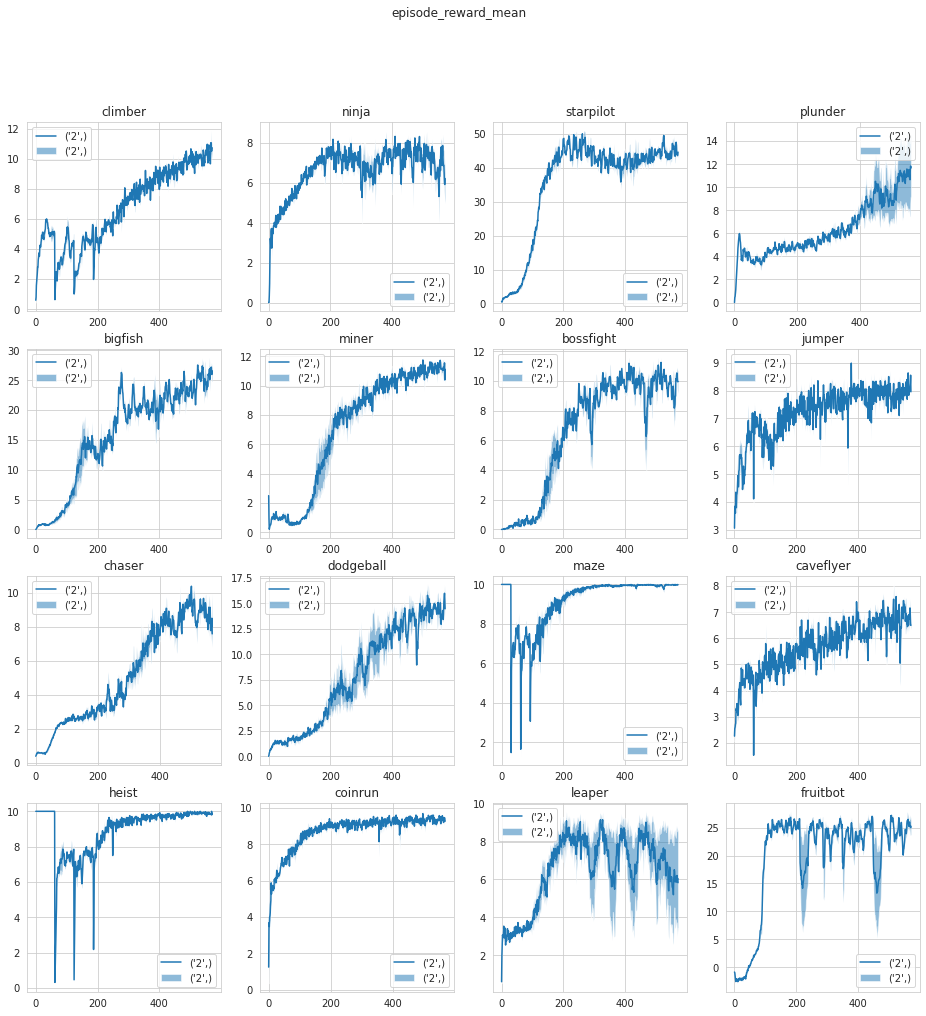

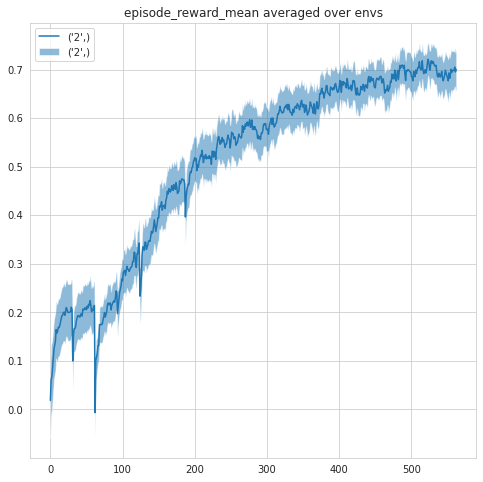

In [247]:
# train: key="episode_reward_mean"
# eval: key="evaluation_episode_reward_mean"
plot_agg_runs(agg_runs, key="episode_reward_mean", average_envs=False)
plot_agg_runs(agg_runs, key="episode_reward_mean", average_envs=True)
# plot_agg_runs(agg_runs, key="evaluation_episode_reward_mean", average_envs=False)
# plot_agg_runs(agg_runs, key="evaluation_episode_reward_mean", average_envs=True)

# Plot based on arbitrary subselect

In [248]:
def run_matches_pairs(run, pairs):
    for field, values in pairs.items():
        if field not in run.params or run.params[field].iloc[0] not in values:
            return False
    return True
    
def subselect_runs(runs, pairs):
    subselect = []
    for run in runs:
        if run_matches_pairs(run, pairs):
            subselect.append(run)
    return subselect

In [249]:
baseline_pairs = {
#         "lr": [0.0005],
#         "model_custom_options_fc_size": [256],
#         "num_envs_per_worker": [64],
#         "model_custom_options_fc_activation": ["relu"],
#         "env_config_env_wrapper_options_frame_stack_options_k": [2],
#         "model_custom_options_weight_init": ["default"],
    "model_custom_options_data_augmentation_options_mode_options_phasic_use_data_aug": [True],
}

pairs_label_list = [(baseline_pairs, "Submission")]

def copy_and_replace(pairs, pairs_to_replace):
    ret = copy.deepcopy(pairs)
    for (k,v) in pairs_to_replace.items():
        ret[k] = v
    return ret

pairs_label_list += [(copy_and_replace(baseline_pairs,
                                       {"model_custom_options_data_augmentation_options_mode_options_phasic_use_data_aug": [False]}), "Without Augmentation")]
# pairs_label_list += [(copy_and_replace(baseline_pairs,
#                                        {"num_envs_per_worker": [128]}), "num_envs_128")]
# pairs_label_list += [(copy_and_replace(baseline_pairs,
#                                        {"grad_clip": [1.0]}), "grad_clip_1.0")]
# pairs_label_list += [(copy_and_replace(baseline_pairs,
#                                        {"model_custom_options_fc_activation": ["tanh"]}), "tanh")]
# pairs_label_list += [(copy_and_replace(baseline_pairs,
#                                        {"env_config_env_wrapper_options_frame_stack_options_k": [3]}), "stack_3")]
# pairs_label_list += [(copy_and_replace(baseline_pairs,
#                                        {"model_custom_options_weight_init": ["orthogonal"]}), "ortho_init")]

label_to_runs = {}
for (pairs, label) in pairs_label_list:
    label_to_runs[label] = subselect_runs(runs, pairs)
    print(f"label: {label}, num runs: {len(label_to_runs[label])}")

label: Submission, num runs: 16
label: Without Augmentation, num runs: 16


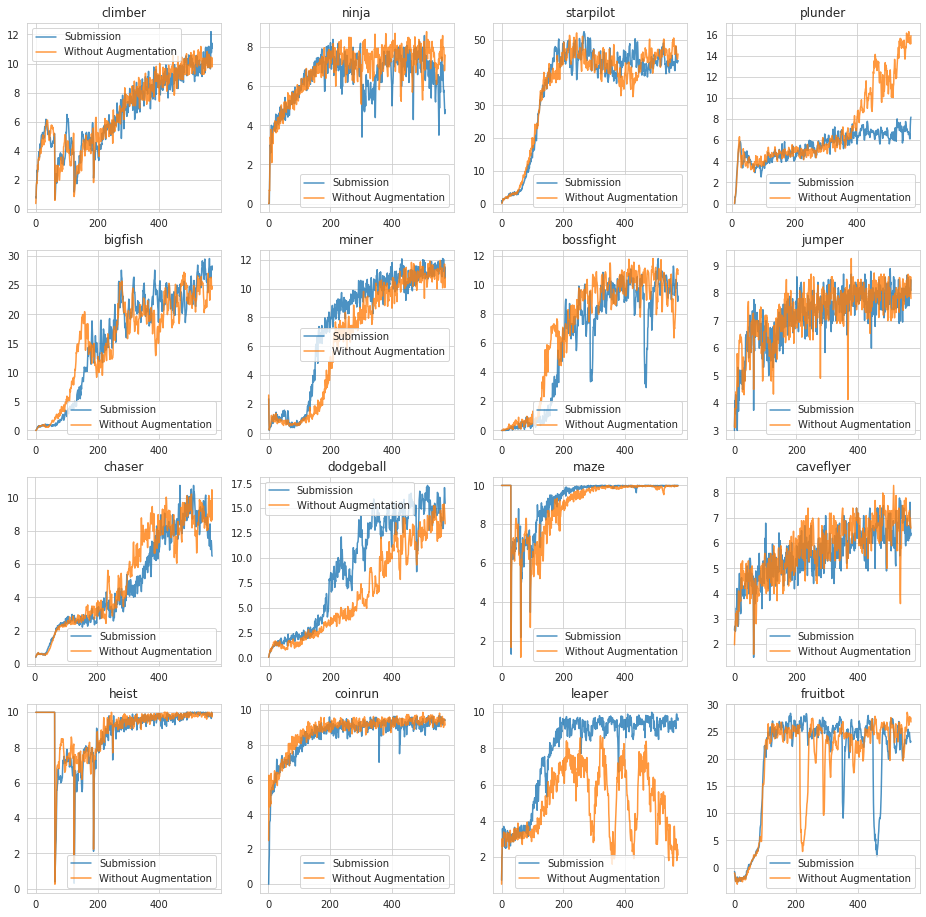

In [250]:
for i, (label, runs_to_plot) in enumerate(label_to_runs.items()):
    plot_runs(runs_to_plot, label=label, make_figure=i == 0)

##### plot the results aggregating across environments for each subset

In [251]:
agg_runs = []
for label, runs_to_agg in label_to_runs.items():
    agg_runs.append(AggregateRun(runs_to_agg, label, label))
print(agg_runs)

[Submission: Submission, Without Augmentation: Without Augmentation]


In [258]:
def get_x_axis_values(n, num_steps=8_000_000):
    return np.linspace(0, num_steps, n)
    
def plot_agg_run2(agg_run, ax, key):
    if len(agg_run) == 0:
        return
    min_len = min(len(r) for r in agg_run.runs)
    values = [r.results[key][:min_len].dropna() for r in agg_run.runs]
    min_len = min(len(v) for v in values)
    values = [v[:min_len] for v in values]
    print(f"Final minimum length: {min_len}")
    if len(values) > 1:
        mean = np.mean(values, axis=0)
        values = np.array([np.array(v) for v in values])
        stderr = np.std(values, axis=0) / np.sqrt(len(values))
        ybelow = mean - stderr
        yabove = mean + stderr
    else:
        mean = np.array(values).reshape(-1)
        ybelow = None
        yabove = None
    
    x = get_x_axis_values(len(mean))
    # x = range(len(mean))
    
    ax.plot(x, mean, label=f"{agg_run.value}")
    if ybelow is not None and yabove is not None:
        # ax.fill_between(x, y1=yabove, y2=ybelow, label=f"{agg_run.value}", alpha=0.5)
        ax.fill_between(x, y1=yabove, y2=ybelow, alpha=0.5)
    ax.set_title(agg_run.runs[0].env)

def plot_agg_runs2(agg_runs, key="episode_reward_mean", average_envs=False, title=None, figsize=(16,16)):
    if average_envs:
        plt.figure(figsize=figsize)
        ax = plt.gca()
        for agg_run in agg_runs:
            plot_agg_run2(agg_run.with_normalized_results(), ax, key=key)
        ax.legend()
        if title is None:
            title = f"{key} averaged over envs"
        plt.title(title, fontsize=20)
        plt.xlabel("Timesteps", fontsize=16)
        plt.ylabel("Normalized Average Reward", fontsize=16)
    else:
        fig, axs = plt.subplots(4, 4, figsize=figsize)
        for i, env_name in enumerate(ENV_NAMES):
            ax_row = i // 4
            ax_col = i % 4
            ax = axs[ax_row, ax_col]
            for agg_run in agg_runs:
                plot_agg_run2(agg_run.for_env(env_name), ax, key=key)
            ax.legend()
        # fig.suptitle(title, fontsize=16)

Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 571
Final minimum length: 563
Final minimum length: 564
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 569
Final minimum length: 569
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 572
Final minimum length: 570
Final minimum length: 570
Final minimum length: 572
Final minimum length: 572
Final minimum length: 571
Final minimum length: 571
Final minimum length: 563
Final minimum length: 564


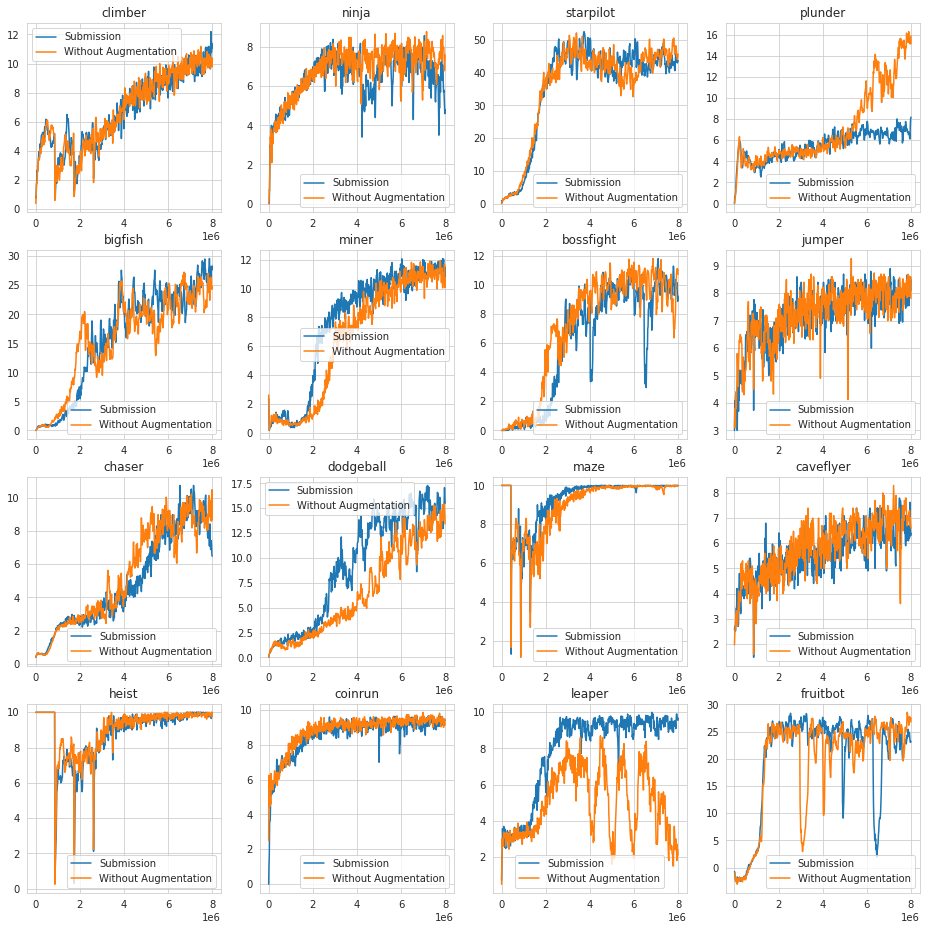

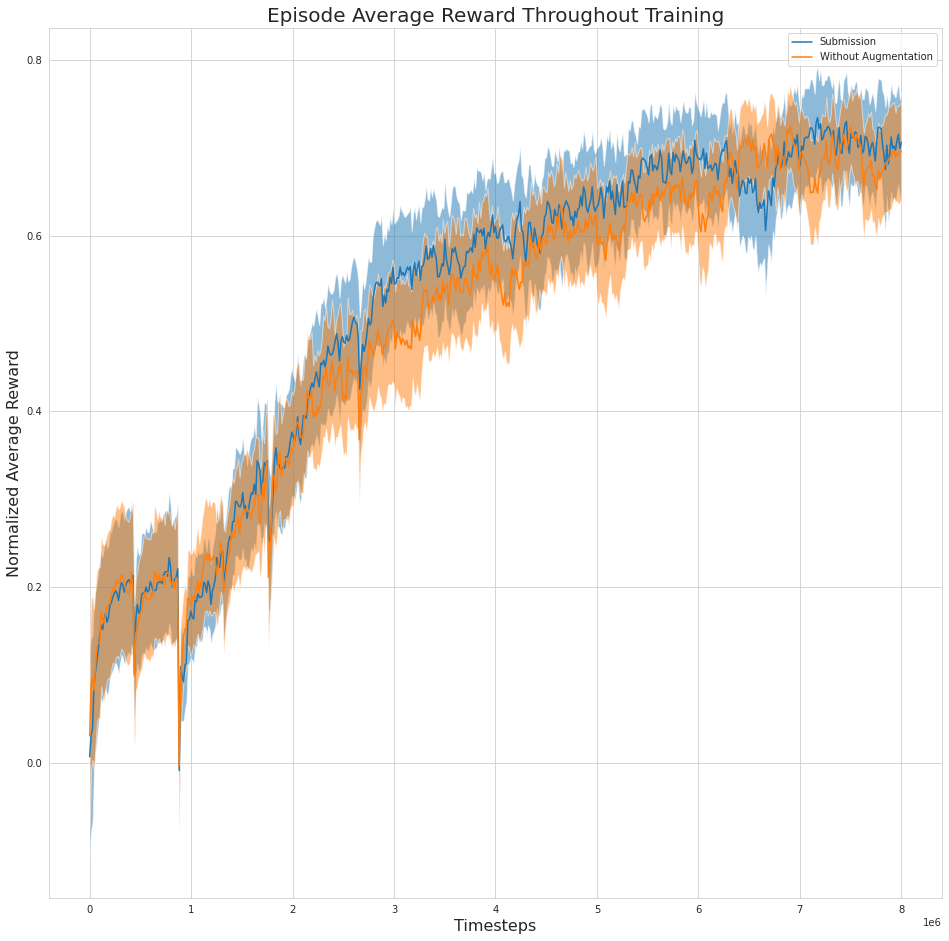

In [262]:
viz_dir = "/home/ubuntu/experiments/results"
plot_agg_runs2(
    agg_runs, 
    key="episode_reward_mean", 
    average_envs=False,
    title="Episode Average Reward"
)
plt.savefig(os.path.join(viz_dir, "sample_efficiency_per_environment.png"), dpi=300)
plt.savefig(os.path.join(viz_dir, "sample_efficiency_per_environment.pdf"), dpi=300)
plt.savefig(os.path.join(viz_dir, "sample_efficiency_per_environment.svg"), dpi=300)

plot_agg_runs2(
    agg_runs, 
    key="episode_reward_mean", 
    average_envs=True,
    title="Episode Average Reward Throughout Training"
)
plt.savefig(os.path.join(viz_dir, "sample_efficiency_aggregate.png"), dpi=300)
plt.savefig(os.path.join(viz_dir, "sample_efficiency_aggregate.pdf"), dpi=300)
plt.savefig(os.path.join(viz_dir, "sample_efficiency_aggregate.svg"), dpi=300)

# Evaluation results

In [ ]:
def plot_run_eval(run, ax, count, label, normalize):
    row = run.as_row()
    if "evaluation_episode_reward_mean" not in row:
        return 0
    y = row["evaluation_episode_reward_mean"].iloc[0]
    if normalize:
        min_r, blind_r, max_r = EASY_GAME_RANGES[run.env]
        y = (y - blind_r) / (max_r - blind_r)
    x = count
    ax.bar(x, y, width=0.5, alpha=0.7, label=f"{label}: {y:.4f}")
    ax.set_title(run.env)
    if label is not None:
        ax.legend()
    return 1
        
def plot_runs_eval(runs, ax_counts=None, label=None, make_figure=True, normalize=True):
    if ax_counts is None:
        ax_counts = collections.defaultdict(int)
    if make_figure:
        fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    else:
        fig = plt.gcf()
        axs = fig.get_axes()
        axs = np.reshape(axs, (4, 4))
    
    for run in runs:
        ax_index = ENV_NAMES.index(run.env)
        ax_row = ax_index // 4
        ax_col = ax_index % 4
        ax_count = ax_counts[ax_index]
        ax_counts[ax_index] += plot_run_eval(run, axs[ax_row, ax_col], ax_count, label=label, normalize=normalize)
    return ax_counts
        

In [ ]:
ax_counts = None
for i, (label, runs_to_plot) in enumerate(label_to_runs.items()):
    ax_counts = plot_runs_eval(runs_to_plot, label=label, ax_counts=ax_counts, make_figure=i == 0)

In [ ]:
def get_eval_scores(runs):
    scores = []
    for run in runs:
        row = run.as_row()
        if "evaluation_episode_reward_mean" not in row:
            continue
        y = row["evaluation_episode_reward_mean"].iloc[0]
        min_r, blind_r, max_r = EASY_GAME_RANGES[run.env]
        y = (y - blind_r) / (max_r - blind_r)
        scores.append(y)
    return scores

In [ ]:
def hist_eval_scores(runs, label, make_figure=True):
    if make_figure:
        plt.figure(figsize=(12,6))
    scores = get_eval_scores(runs)
    plt.hist(scores, bins=5, alpha=0.4, width=0.025, label=f"{label}: {np.mean(scores):.4f}")
    plt.legend()
    plt.title("histogram of normalized evaluation scores")

In [ ]:
for i, (label, runs_to_plot) in enumerate(label_to_runs.items()):
    hist_eval_scores(runs_to_plot, label=label, make_figure=i == 0)

In [ ]:
hist_eval_scores(bs_1628_sub, label="batch_size_1628", make_figure=False)
hist_eval_scores(baseline_sub, label="batch_size_814", make_figure=False)

#### If we select the best run for each env, what's the normalized score?

In [ ]:
best_scores = collections.defaultdict(float)
for run in runs:
    row = run.as_row()
    if "evaluation_episode_reward_mean" not in row:
        continue
    y = row["evaluation_episode_reward_mean"].iloc[0]
    min_r, blind_r, max_r = EASY_GAME_RANGES[run.env]
    y = (y - blind_r) / (max_r - blind_r)
    best_scores[run.env] = max(best_scores[run.env], y)    

In [ ]:
scores = []
for env, score in best_scores.items():
    scores.append(score)
    print(f"{env}: {score:.2f}")
print(f"\nmean: {np.mean(scores):.2f}")

array([0.        , 0.00909091, 0.01818182, 0.02727273, 0.03636364,
       0.04545455, 0.05454545, 0.06363636, 0.07272727, 0.08181818,
       0.09090909, 0.1       , 0.10909091, 0.11818182, 0.12727273,
       0.13636364, 0.14545455, 0.15454545, 0.16363636, 0.17272727,
       0.18181818, 0.19090909, 0.2       , 0.20909091, 0.21818182,
       0.22727273, 0.23636364, 0.24545455, 0.25454545, 0.26363636,
       0.27272727, 0.28181818, 0.29090909, 0.3       , 0.30909091,
       0.31818182, 0.32727273, 0.33636364, 0.34545455, 0.35454545,
       0.36363636, 0.37272727, 0.38181818, 0.39090909, 0.4       ,
       0.40909091, 0.41818182, 0.42727273, 0.43636364, 0.44545455,
       0.45454545, 0.46363636, 0.47272727, 0.48181818, 0.49090909,
       0.5       , 0.50909091, 0.51818182, 0.52727273, 0.53636364,
       0.54545455, 0.55454545, 0.56363636, 0.57272727, 0.58181818,
       0.59090909, 0.6       , 0.60909091, 0.61818182, 0.62727273,
       0.63636364, 0.64545455, 0.65454545, 0.66363636, 0.67272